### Project 4 - West Nile Virus in Chicago

<p><b>Statement of Purpose</b></p>
<p>West Nile Virus is a contagious mosquito-born disease the City of Chicago is trying to control and/or eradicate.</p>
<p>For this project we were given several datasets containing information regarding mosquitos found in traps,  the presence in them of West Nile Virus, ambient weather conditions, and pesticide spraying conducted all mapped to GPS latitude and longitude coordinates over the years 2007-2013.</p>
<p>We plan to use thorough data analysis, careful feature selection and engineering, bootstrapping, and a variety of classification models to effectively predict the presence of West Nile Virus against a test dataset containing dates, locations, and trap numbers but not the number of mosquitos found in the traps.</p>

In [463]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, BaggingClassifier, RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import SVC

from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

%matplotlib inline
pd.set_option('display.max_columns', 999)

### Preliminary EDA
<p>Here we are changing values in the weather table where missing ('M') or trace ('  T') are entered to be averages of the preceding and following days to retain relevant numeric values.</p>
<p>Also casting the date column to datetime datatype and then extracting the year as a seperate column.</p>

In [464]:
def Tavg(row):
    '''
    Function to impute missing values for temperature
    '''
    if row['Tavg']!='M':
        return row['Tavg']
    else:
        return (row['Tmax']+row['Tmin'])/2

In [465]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
spray = pd.read_csv('data/spray.csv')
weather = pd.read_csv('data/weather.csv')

### changing '  T' and 'M' values for PrecipTotal in weather dataset
weather['PrecipTotal'] = weather['PrecipTotal'].replace('  T', '0.001')
weather['PrecipTotal'].at[117] = '0.00'
weather['PrecipTotal'].at[119] = '0.00'

### changing '  T' and 'M' values for WetBulb in weather dataset
weather['WetBulb'].at[848] = 70
weather['WetBulb'].at[2415] = 61
weather['WetBulb'].at[2410] = 66
weather['WetBulb'].at[2412] = 67

### making PrecipTotal and WetBulb int datatype
weather['PrecipTotal'] = pd.to_numeric(weather['PrecipTotal'])
weather['WetBulb'] = pd.to_numeric(weather['WetBulb'])

weather['Tavg'] = weather.apply(Tavg,axis=1)
weather['Tavg'] = pd.to_numeric(weather['Tavg'])

train['Date'] = pd.to_datetime(train['Date'])
train['Year'] = train['Date'].map(lambda x: x.year)

test['Date'] = pd.to_datetime(test['Date'])
test['Year'] = test['Date'].map(lambda x: x.year)

weather['Date'] = pd.to_datetime(weather['Date'])
weather['Year'] = weather['Date'].map(lambda x: x.year)

spray['Date'] = pd.to_datetime(spray['Date'])
spray['Year'] = spray['Date'].map(lambda x: x.year)

train.dtypes

Date                      datetime64[ns]
Address                           object
Species                           object
Block                              int64
Street                            object
Trap                              object
AddressNumberAndStreet            object
Latitude                         float64
Longitude                        float64
AddressAccuracy                    int64
NumMosquitos                       int64
WnvPresent                         int64
Year                               int64
dtype: object

### Examining the Spray DataFrame for relevant dates as well as number of datapoints.

In [466]:
spray['Date'].value_counts().sort_index()

2011-08-29      95
2011-09-07    2114
2013-07-17    2202
2013-07-25    1607
2013-08-08    1195
2013-08-15    2668
2013-08-16     141
2013-08-22    1587
2013-08-29    2302
2013-09-05     924
Name: Date, dtype: int64

In [467]:
# import geoplotlib

# train = pd.read_csv('data/train.csv')
# train['lat']=train['Latitude']
# train['lon']=train['Longitude']
# geoplotlib.dot(train)
# geoplotlib.show()

### Function to merge Train or Test DataFrame with Weather data between any two sequential dates

In [468]:
def merge_wnv_dfs(df, weather_df, min_date, max_date, weather_cols=['Tmax', 'Tmin', 'Tavg', 'DewPoint', 
                                                  'WetBulb', 'PrecipTotal']):
    '''
    Merges mosquito-related data with weather data using Date as an index
    Uses an optional parameter of a list of weather columns to add
    '''
    ### set Date as index on Train on Test dataframe
    df = df.set_index(['Date'])
    df = df[(df.index >= min_date) & (df.index <= max_date)]
    
    ### set Date as index on Weather on Weather dataframe
    weather_df = weather_df.set_index(['Date'])
    
    ### reduce Weather dataframe to relevant/requested columns
    weather_df = weather_df[weather_cols]
    
    ### join Train on Test dataframe with Weather data
    df = df.join(weather_df)
    
    ### double-checking for T values
    if 'PrecipTotal' in weather_cols:
        df['PrecipTotal'] = df['PrecipTotal'].replace('  T', '0.001')
    return df

In [469]:
### one year
train_2009 = merge_wnv_dfs(train, weather, '2009-01-01', '2009-12-31')
train_2009.head(2)
### one year
# train_2009_one_week = merge_wnv_dfs(train, weather, '2009-09-15', '2009-09-22')
# train_2009_one_week.tail(2)

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Year,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal
Date,,,,,,,,,,,,,,,,,,
2009-05-28,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2,0,2009,62,54,58.0,51,54,0.0
2009-05-28,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2,0,2009,64,55,60.0,51,54,0.0


### Function to create merged entire Test/Train DataFrames with weather information using Station 1 data for top third of recorded latitudes and Station 2 data for bottom two thirds.

In [470]:
def merge_all_wnv_dfs(df, weather_df, weather_cols=['Date', 'Station', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'PrecipTotal']):
    ### takes directly imported data from train/test (prior to indexing Date column)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index(['Date'])
    
    ### takes directly imported data from weather (prior to indexing Date column
    weather_df = weather_df[weather_cols]
    weather_df['Date'] = pd.to_datetime(weather_df['Date'])
    weather_df = weather_df.set_index(['Date'])
    
    ### create empty df matching weather cols passed in to append rows to
    weather_to_merge_df = pd.DataFrame(columns=weather_cols)
    weather_to_merge_df = weather_to_merge_df.set_index(['Date'])

    ### iterate over all rows in train/test dataframe and append weather data row
    ### to new df based on latitude
    for index, row in df.iterrows():
        if row['Latitude'] >= 41.893:
            weather_row = weather_df[(weather_df.index == index) & (weather_df['Station'] == 1)]
        else:
            weather_row = weather_df[(weather_df.index == index) & (weather_df['Station'] == 2)]
        weather_to_merge_df = weather_to_merge_df.append(weather_row)

    ### drop Station columns
    weather_to_merge_df = weather_to_merge_df.drop(['Station'], axis=1)
    ### concat two dfs together
    df = pd.concat([df, weather_to_merge_df], axis=1)
    return df
            
####################
### NOTE: Only run the two lines below if you have about 1/2-1 hours to allow it to run
###       This data has been saved off into .csv files to avoid having to generate it each time.
####################
# train_weather = merge_all_wnv_dfs(train, weather)
# test_weather = merge_all_wnv_dfs(test, weather)
train_weather = pd.read_csv('data/train_weather.csv')
test_weather = pd.read_csv('data/test_weather.csv')

train_weather['Date'] = pd.to_datetime(train_weather['Date'])
train_weather = train_weather.set_index(['Date'])

test_weather['Date'] = pd.to_datetime(test_weather['Date'])
test_weather = test_weather.set_index(['Date'])

# train_weather.info()

### Defining function to output line chart of mosquito counts for any date range

In [471]:
train_weather.head()

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal
Date,,,,,,,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,88,60,74,58,65,0.0
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,88,60,74,58,65,0.0
2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,88,60,74,58,65,0.0
2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,88,60,74,58,65,0.0
2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,88,60,74,58,65,0.0


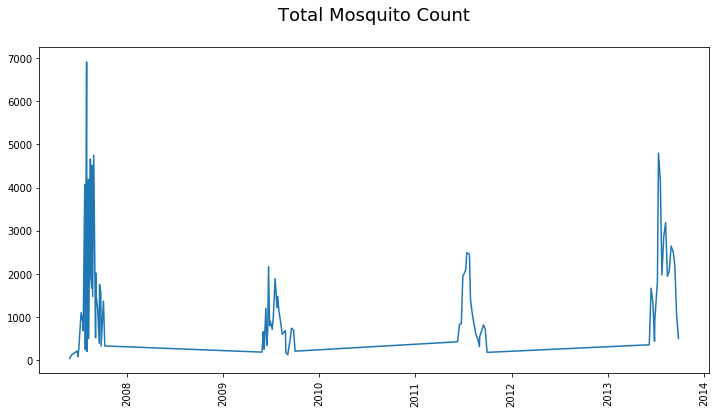

In [472]:
def line_chart_mosquito_count(df):
    plt.figure(figsize=(12, 6))
    plt.xticks(rotation=90)
    plt.title('Total Mosquito Count\n', fontsize='18')
    plt.plot(df['NumMosquitos'].groupby(df.index).sum())

line_chart_mosquito_count(train_weather)

### Defining function to output line chart for weather stats

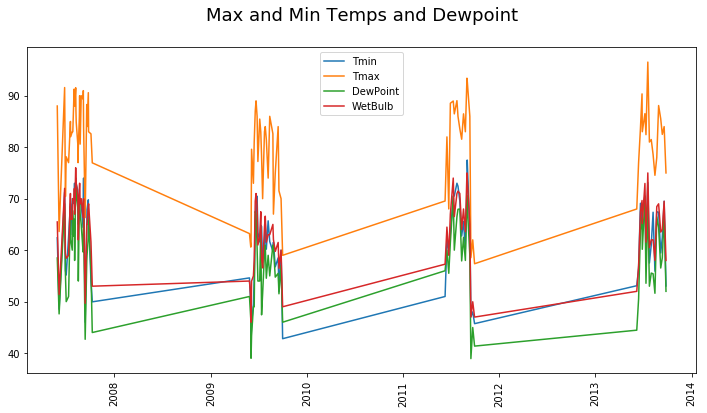

In [473]:
def line_chart_weather(df):
    plt.figure(figsize=(12, 6))
    plt.xticks(rotation=90)
    plt.plot(df['Tmin'].groupby(df.index).mean())
    plt.plot(df['Tmax'].groupby(df.index).mean())
    plt.plot(df['DewPoint'].groupby(df.index).mean())
    plt.plot(df['WetBulb'].groupby(df.index).mean())
    plt.title('Max and Min Temps and Dewpoint\n', fontsize='18')
    plt.legend()
    
line_chart_weather(train_weather)

### Defining function to show precipitation for any date range

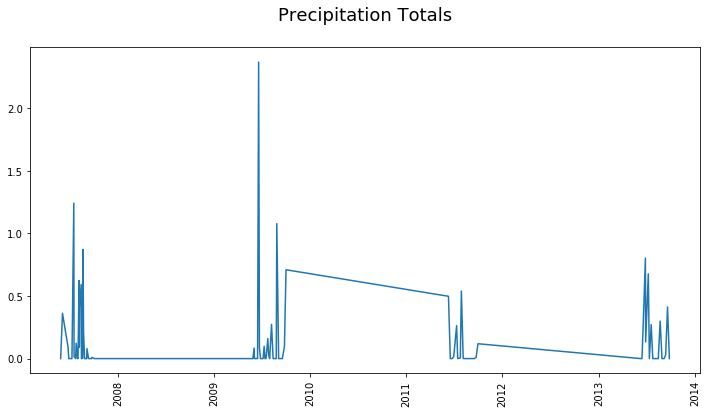

In [474]:
def line_chart_precip(df):
    plt.figure(figsize=(12, 6))
    plt.xticks(rotation=90)
    plt.title('Precipitation Totals\n', fontsize='18')
    plt.plot(df['PrecipTotal'].groupby(df.index).mean())
    
line_chart_precip(train_weather)

### Defining function to generate data to generate side-by side 10x10 one-day mosquito and WNV heatmaps for a list of N dates.

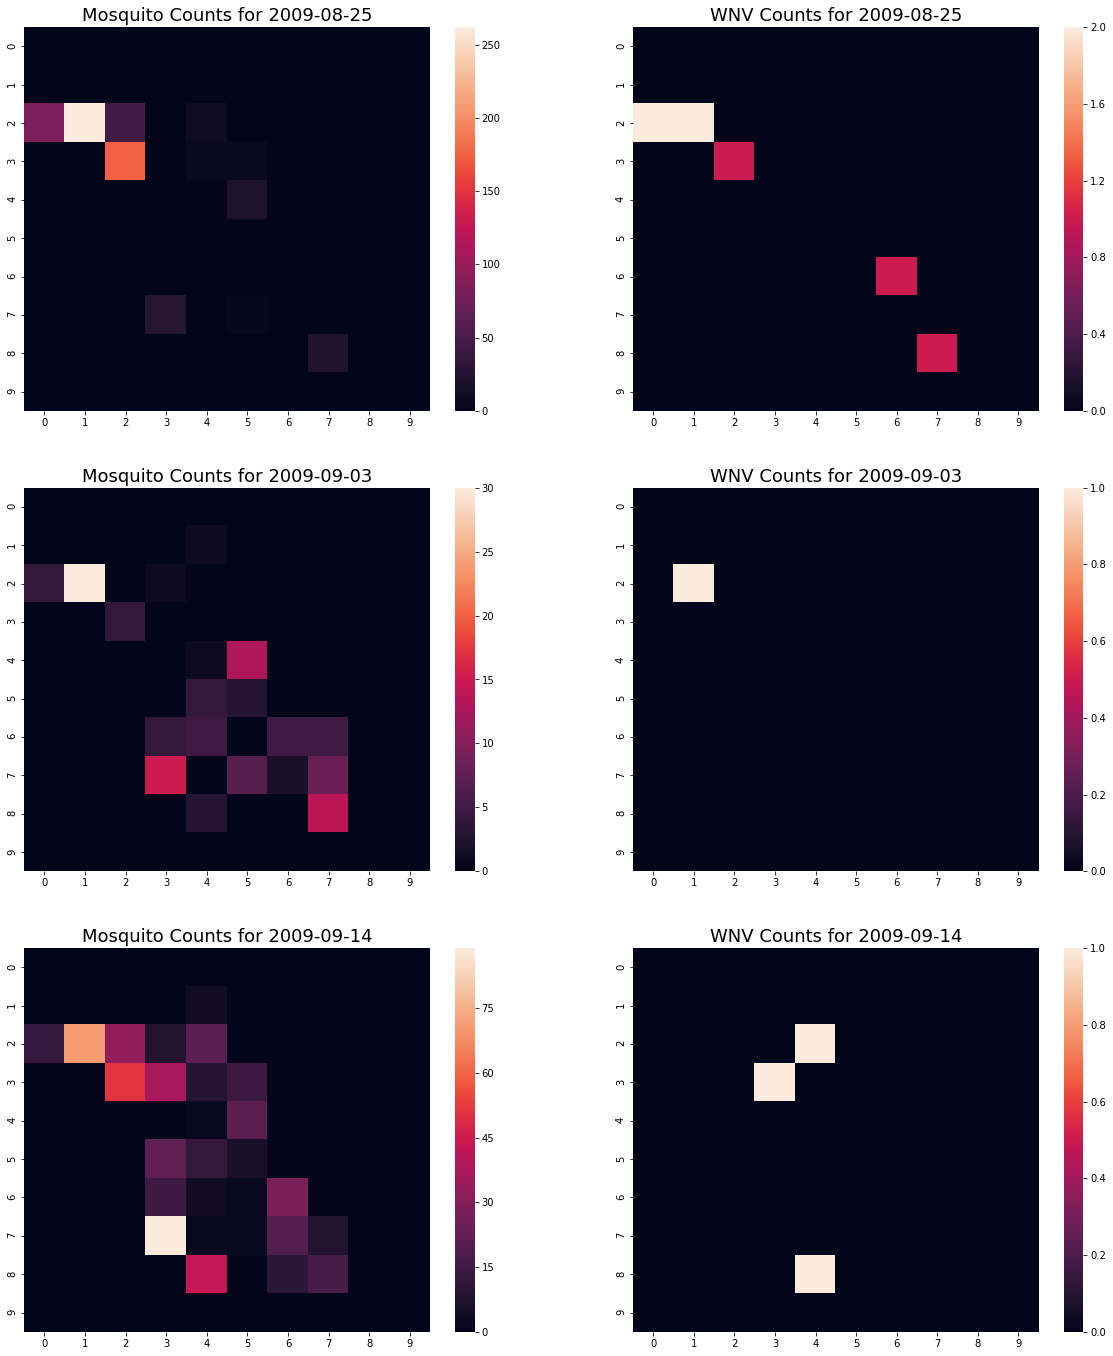

In [475]:
def mosquitos_by_gps(df, dates=[], height=8, width=20):
    fig, axes = plt.subplots(len(dates), 2, figsize=(width, height * len(dates)), squeeze=False)
    
    lats = np.linspace(42.1, 41.6, 11)
    longs = np.linspace(-87.95, -87.4, 11)
    
    k = 0
    for cur_date in dates:
        date_df = df[df.index == cur_date]
        mosquitos = []
        wnvs = []
        for i in range(0, 10):
            mosquitos_list = []
            wnvs_list = []
            for j in range(0, 10):
                grid_square = date_df[(date_df['Latitude'] <= lats[i]) & (date_df['Latitude'] >= lats[i+1])]
                grid_square = grid_square[(grid_square['Longitude'] >= longs[j]) & (grid_square['Longitude'] <= longs[j+1])]
                mosquitos_list.append(grid_square['NumMosquitos'].sum())
                wnvs_list.append(grid_square['WnvPresent'].sum())
            mosquitos.append(mosquitos_list)
            wnvs.append(wnvs_list)
        ax_curr = axes[k, 0]
        sns.heatmap(mosquitos, ax=ax_curr)
        ax_curr.set_title('Mosquito Counts for ' + str(cur_date), fontsize=18)        
        ax_curr = axes[k, 1]
        sns.heatmap(wnvs, ax=ax_curr)
        ax_curr.set_title('WNV Counts for ' + str(cur_date), fontsize=18) 
        k += 1

mosquitos_by_gps(train_weather, ['2009-08-25', '2009-09-03', '2009-09-14'])

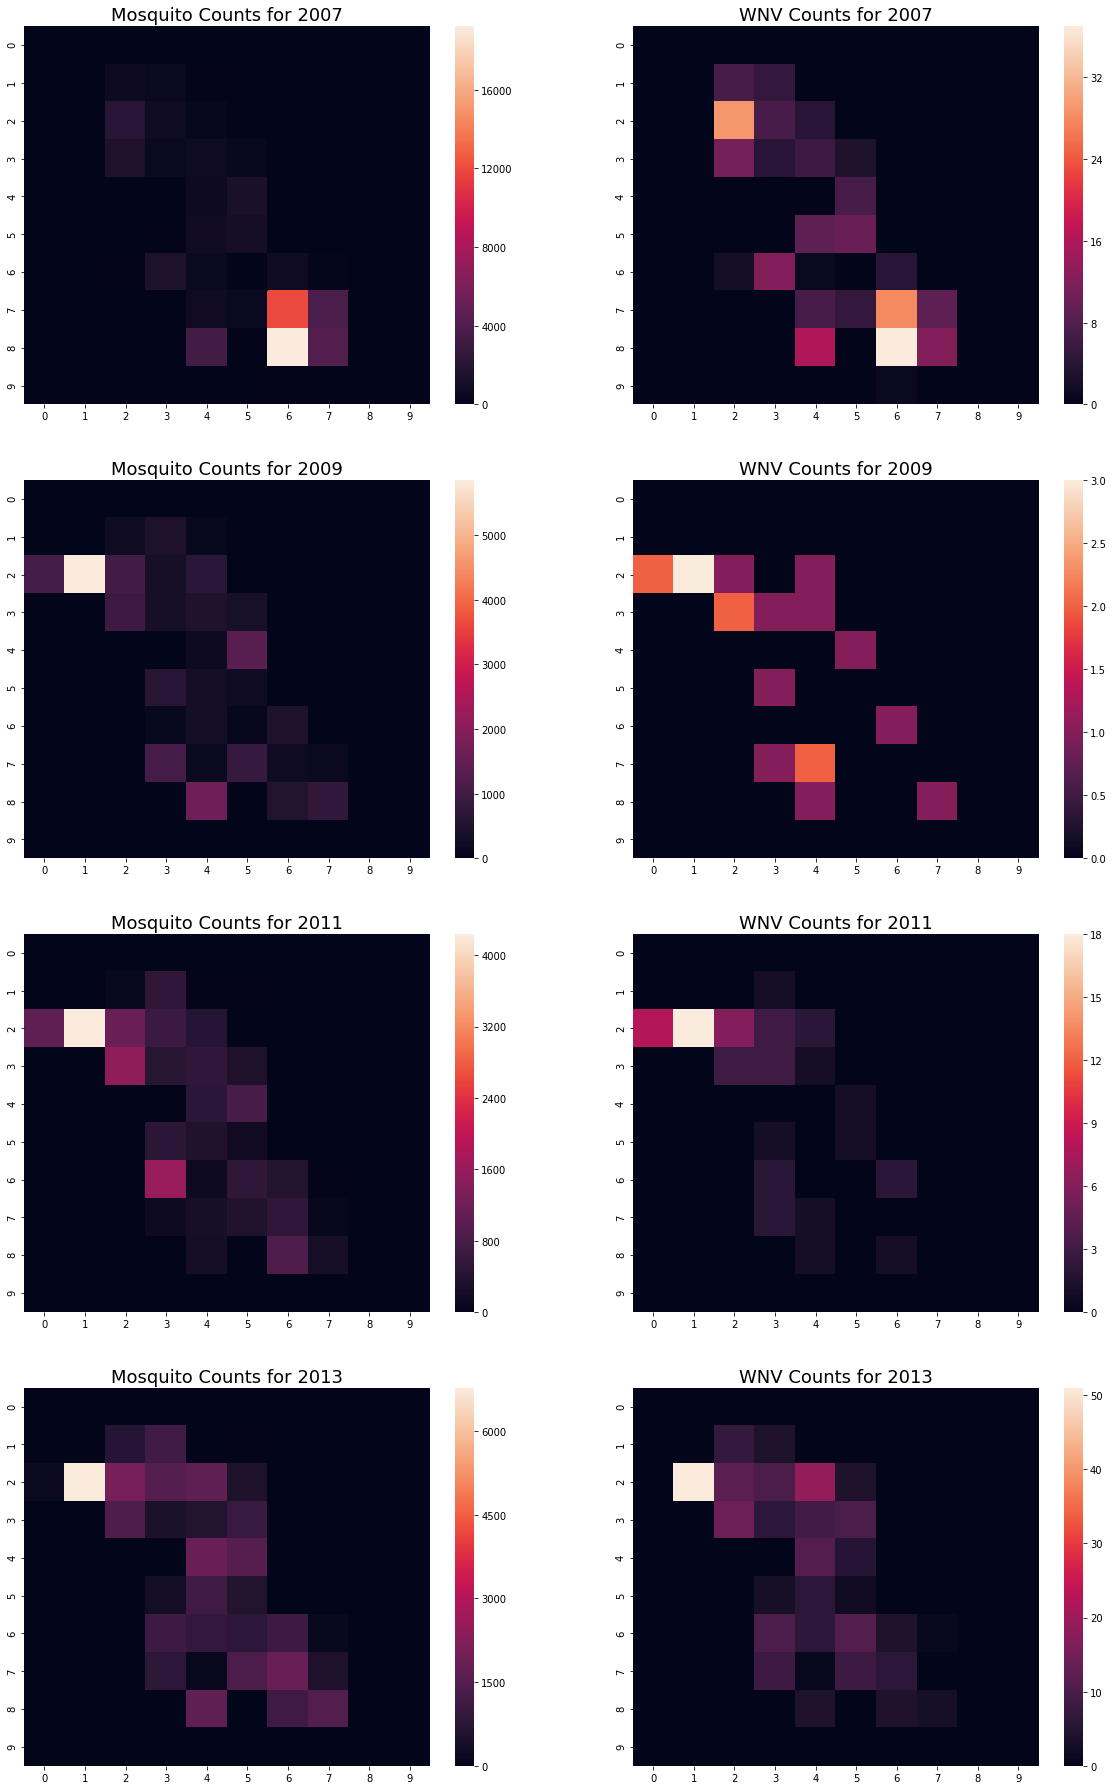

In [476]:
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

def mosquitos_by_year_by_gps(df, years, height=8, width=20):
    fig, axes = plt.subplots(len(years), 2, figsize=(width, height * len(years)), squeeze=False)
    
    lats = np.linspace(42.1, 41.6, 11)
    longs = np.linspace(-87.95, -87.4, 11)
    
    k = 0
    for year in years:
        date_df = df[df['Year'] == year]
        mosquitos = []
        wnvs = []
        for i in range(0, 10):
            mosquitos_list = []
            wnvs_list = []
            for j in range(0, 10):
                grid_square = date_df[(date_df['Latitude'] <= lats[i]) & (date_df['Latitude'] >= lats[i+1])]
                grid_square = grid_square[(grid_square['Longitude'] >= longs[j]) & (grid_square['Longitude'] <= longs[j+1])]
                mosquitos_list.append(grid_square['NumMosquitos'].sum())
                wnvs_list.append(grid_square['WnvPresent'].sum())
            mosquitos.append(mosquitos_list)
            wnvs.append(wnvs_list)
        ax_curr = axes[k, 0]
        sns.heatmap(mosquitos, ax=ax_curr)
        ax_curr.set_title('Mosquito Counts for ' + str(year), fontsize=18, color='k')        
        ax_curr = axes[k, 1]
        sns.heatmap(wnvs, ax=ax_curr)
        ax_curr.set_title('WNV Counts for ' + str(year), fontsize=18, color='k') 
        k += 1

mosquitos_by_year_by_gps(train, [2007, 2009, 2011, 2013])

### Prep side dataset by running get_dummies() on copy on Species column

In [477]:
train_species = train.set_index(['Date'])
train_species = pd.get_dummies(train_species['Species'])
train_species = train_species.groupby(train_species.index).sum()

### Generate line chart of species counts for entire recorded period from 2007-2013.

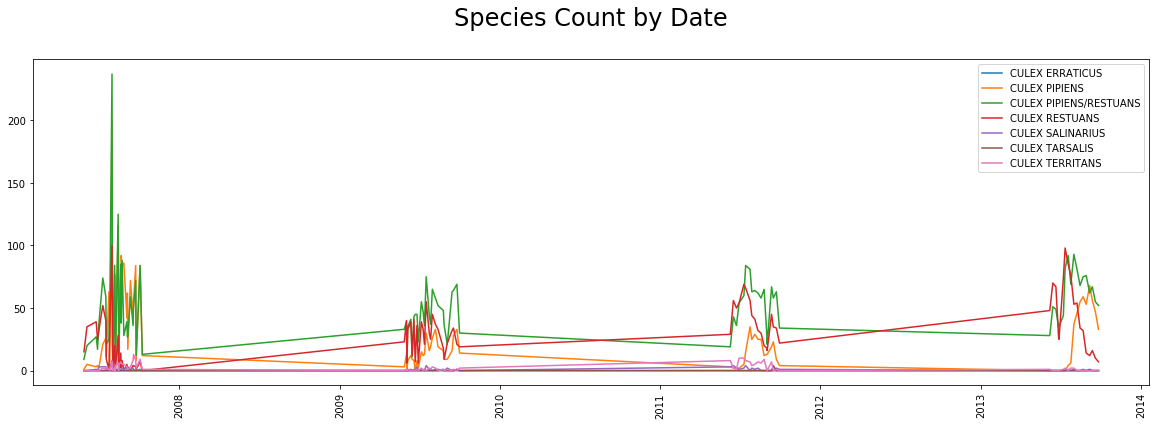

In [478]:
train_species = train_species.groupby(train_species.index).sum()

plt.figure(figsize=(20, 6))
plt.xticks(rotation=90)
plt.plot(train_species)
plt.title('Species Count by Date\n', fontsize=24)
plt.legend(labels=['CULEX ERRATICUS', 'CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX SALINARIUS', 'CULEX TARSALIS', 'CULEX TERRITANS'])

### Creating X and eventually y non-destructively by copying the train_weather df    

In [535]:
X = train_weather.copy()

### dropping non-numeric columns
X = X.drop(['Address', 'Street', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy'], axis=1)

### adding test-only traps to X(train) so the shapes match
test_only_traps = ['T002A', 'T002B', 'T065A', 'T090A', 'T090B', 'T090C', 'T128A', 'T200A', 'T200B', 'T218A', 'T218B', 'T218C', 'T234']
for trap in test_only_traps:
    X[trap] = 0

### Creating function to assign mosquito counts to new species columns

In [536]:
def add_nummosq_to_species(df, wnv_pos_only=True):
    '''
    Adds mosquito count to species using manually generated "dummy" columns
    Optional parameter to only add numbers for WNV+ rows
    '''
    df = df.sort_index()
    df = df.reset_index()
    species_list = ['Species_CULEX ERRATICUS', 'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS', 'UNSPECIFIED CULEX'] 

    for species in species_list:
        df[species] = 0

    for index, row in df.iterrows():
        species = 'Species_' + row['Species'].upper()
        if wnv_pos_only == True:
            if row['WnvPresent'] == 1:
                df.loc[index, species] = row['NumMosquitos']
        else:
            df.loc[index, species] = row['NumMosquitos']

    df = df.set_index('Date')
    return df

### populates new species cols with mosquito count if WnvPresent == 1
# X = add_nummosq_to_species(X)

### populates new species cols with mosquito count regardless of WNV+/-
X = add_nummosq_to_species(X, False)
X.tail(2)

,Species,Block,Trap,NumMosquitos,WnvPresent,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,T002A,T002B,T065A,T090A,T090B,T090C,T128A,T200A,T200B,T218A,T218B,T218C,T234,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,UNSPECIFIED CULEX
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-09-26,CULEX PIPIENS/RESTUANS,71,T233,5,0,75,50,63,52,58,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0
2013-09-26,CULEX PIPIENS/RESTUANS,42,T235,1,0,75,55,65,52,58,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


### Bootstrapping

In [537]:
def bootstrap_wnv(df, bs_size=9404):
    '''
    Bootstraps dataset to account for imbalance in WNV+ rows compared to WNV- rows
    Row size default of 9404 directly related to numbers in this dataset
    '''
    X_boot = df.reset_index()
    ind_train = np.random.choice(list(X_boot[X_boot['WnvPresent'] == 1].index), size=bs_size, replace=True)

    train_ind = X_boot.iloc[ind_train,:]
    train_ind.index = list(range(551,9955))

    X_boot = pd.concat([X_boot, train_ind])
    X_boot = X_boot.set_index('Date')
    return X_boot

X_boot = bootstrap_wnv(X)
X_boot['WnvPresent'].value_counts()

1    9955
0    9955
Name: WnvPresent, dtype: int64

### Prep Train data for model testing

In [538]:
def create_train_testing_set(df, manual_species=True):
    '''
    Creates X with option to run get_dummies() on Species or use manually assigned species columns with mosquito counts
    '''
    y = df['WnvPresent']
    X = df.drop(['NumMosquitos', 'WnvPresent'], axis=1)

    if manual_species == True:
        X = X.drop(['Species'], axis=1)
        X = pd.get_dummies(X, columns=['Trap', 'Block'])
    else:
        X = pd.get_dummies(X, columns=['Species', 'Trap', 'Block'])
    X['Block_26'] = 0
    return X, y

X, y = create_train_testing_set(X_boot)
# X, y = create_train_testing_set(X_boot, False)
X['UNSPECIFIED CULEX'] = 0
X.shape

(19910, 228)

In [539]:
### making sure NumMosquitos and WnvPresent are dropped
X.head(1)

,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,T002A,T002B,T065A,T090A,T090B,T090C,T128A,T200A,T200B,T218A,T218B,T218C,T234,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,UNSPECIFIED CULEX,Trap_T001,Trap_T002,Trap_T003,Trap_T004,Trap_T005,Trap_T006,Trap_T007,Trap_T008,Trap_T009,Trap_T011,Trap_T012,Trap_T013,Trap_T014,Trap_T015,Trap_T016,Trap_T017,Trap_T018,Trap_T019,Trap_T025,Trap_T027,Trap_T028,Trap_T030,Trap_T031,Trap_T033,Trap_T034,Trap_T035,Trap_T036,Trap_T037,Trap_T039,Trap_T040,Trap_T043,Trap_T044,Trap_T045,Trap_T046,Trap_T047,Trap_T048,Trap_T049,Trap_T050,Trap_T051,Trap_T054,Trap_T054C,Trap_T060,Trap_T061,Trap_T062,Trap_T063,Trap_T065,Trap_T066,Trap_T067,Trap_T069,Trap_T070,Trap_T071,Trap_T072,Trap_T073,Trap_T074,Trap_T075,Trap_T076,Trap_T077,Trap_T078,Trap_T079,Trap_T080,Trap_T081,Trap_T082,Trap_T083,Trap_T084,Trap_T085,Trap_T086,Trap_T088,Trap_T089,Trap_T090,Trap_T091,Trap_T092,Trap_T094,Trap_T094B,Trap_T095,Trap_T096,Trap_T097,Trap_T099,Trap_T100,Trap_T102,Trap_T103,Trap_T107,Trap_T114,Trap_T115,Trap_T128,Trap_T129,Trap_T135,Trap_T138,Trap_T141,Trap_T142,Trap_T143,Trap_T144,Trap_T145,Trap_T146,Trap_T147,Trap_T148,Trap_T149,Trap_T150,Trap_T151,Trap_T152,Trap_T153,Trap_T154,Trap_T155,Trap_T156,Trap_T157,Trap_T158,Trap_T159,Trap_T160,Trap_T161,Trap_T162,Trap_T200,Trap_T206,Trap_T209,Trap_T212,Trap_T215,Trap_T218,Trap_T219,Trap_T220,Trap_T221,Trap_T222,Trap_T223,Trap_T224,Trap_T225,Trap_T226,Trap_T227,Trap_T228,Trap_T229,Trap_T230,Trap_T231,Trap_T232,Trap_T233,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903,Block_10,Block_11,Block_12,Block_13,Block_14,Block_15,Block_17,Block_18,Block_20,Block_21,Block_22,Block_24,Block_25,Block_27,Block_28,Block_29,Block_30,Block_33,Block_34,Block_35,Block_36,Block_37,Block_38,Block_39,Block_40,Block_41,Block_42,Block_43,Block_45,Block_46,Block_47,Block_48,Block_49,Block_50,Block_51,Block_52,Block_53,Block_55,Block_58,Block_60,Block_61,Block_62,Block_63,Block_64,Block_65,Block_66,Block_67,Block_68,Block_70,Block_71,Block_72,Block_73,Block_75,Block_77,Block_79,Block_80,Block_81,Block_82,Block_89,Block_90,Block_91,Block_93,Block_96,Block_98,Block_26
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-05-29,88,60,74,58,65,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Prep Test data for model testing

In [540]:
def create_test_testing_set(df):
    # X_test = test_weather.copy()
    X_test = df.copy()
    X_test_ids = pd.DataFrame(X_test['Id'])
    X_test_ids = X_test_ids.reset_index()
    X_test_ids = X_test_ids.drop(['Date'], axis=1)

    X_test = X_test.drop(['Id', 'Address', 'Street', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy'], axis=1)
    X_test = pd.get_dummies(X_test, columns=['Trap', 'Species', 'Block'])
    return X_test, X_test_ids

X_test, X_test_ids = create_test_testing_set(test_weather)
X_test.shape

(116293, 228)

In [541]:
# X_test.head()

### Create train-validation split since our test data does not contain number of mosquitos

In [542]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=314)

### Create Logistic Regression model

In [543]:
log_reg = LogisticRegression(C=7)
log_reg.fit(X_train, y_train)
log_reg.score(X_train, y_train)

0.75575805410059549

In [544]:
cross_val_score(log_reg, X_val, y_val), cross_val_score(log_reg, X_val, y_val).mean()

(array([ 0.74284279,  0.74886991,  0.75690608]), 0.74953959484346233)

In [545]:
preds = log_reg.predict(X_test)
preds_df = pd.DataFrame(preds, columns=['WnvPresent'])
preds_df['WnvPresent'].value_counts()

0    95747
1    20546
Name: WnvPresent, dtype: int64

In [546]:
log_reg_sub = pd.concat([X_test_ids, preds_df], ignore_index=True, axis=1)
log_reg_sub = log_reg_sub.rename(columns={0: "Id", 1: "WnvPresent"})
log_reg_sub.to_csv('log_reg2_submission.csv', index=False)

### Create RandomForestClassifier model

In [547]:
rf_clf = RandomForestClassifier(n_estimators=150, max_features='auto', max_depth=40)
rf_clf.fit(X_train, y_train)
rf_clf.score(X_train, y_train)

0.98191863385233547

In [548]:
cross_val_score(rf_clf, X_val, y_val), cross_val_score(rf_clf, X_val, y_val).mean()

(array([ 0.92566549,  0.94023104,  0.93420392]), 0.93152519671856693)

### Generate predictions

In [549]:
preds = rf_clf.predict(X_test)
preds_df = pd.DataFrame(preds, columns=['WnvPresent'])
preds_df['WnvPresent'].value_counts()

0    116293
Name: WnvPresent, dtype: int64

### Concat ids and predictions, name the columns, and export to .csv file

In [567]:
rf_sub = pd.concat([X_test_ids, preds_df], ignore_index=True, axis=1)
rf_sub = rf_sub.rename(columns={0: "Id", 1: "WnvPresent"})
rf_sub.to_csv('rf2_submission.csv', index=False)

### Trying ExtraTreesClassifier

In [551]:
et_clf = ExtraTreesClassifier(max_depth=100, min_samples_leaf=3, min_samples_split=3)
et_clf.fit(X_train, y_train)
et_clf.score(X_train, y_train)

0.93391691181746428

In [552]:
cross_val_score(et_clf, X_val, y_val), cross_val_score(et_clf, X_val, y_val).mean()

(array([ 0.85585133,  0.85836263,  0.85082873]), 0.85367487024945587)

In [553]:
preds = et_clf.predict(X_test)
preds_df = pd.DataFrame(preds, columns=['WnvPresent'])
preds_df['WnvPresent'].value_counts()

0    113793
1      2500
Name: WnvPresent, dtype: int64

In [554]:
et_sub = pd.concat([X_test_ids, preds_df], ignore_index=True, axis=1)
et_sub = et_sub.rename(columns={0: "Id", 1: "WnvPresent"})
et_sub.to_csv('et2_submission.csv', index=False)

### Trying AdaBoostClassifier with ExtraTrees

In [555]:
ada_clf = AdaBoostClassifier(base_estimator=et_clf)
ada_clf.fit(X_train, y_train)
ada_clf.score(X_train, y_train)

0.98299490564683933

In [556]:
cross_val_score(ada_clf, X_val, y_val), cross_val_score(ada_clf, X_val, y_val).mean()

(array([ 0.93721748,  0.93771974,  0.94224008]), 0.94023103967855359)

In [557]:
preds = ada_clf.predict(X_test)
preds_df = pd.DataFrame(preds, columns=['WnvPresent'])
preds_df['WnvPresent'].value_counts()

0    116293
Name: WnvPresent, dtype: int64

In [558]:
ada_sub = pd.concat([X_test_ids, preds_df], ignore_index=True, axis=1)
ada_sub = ada_sub.rename(columns={0: "Id", 1: "WnvPresent"})
ada_sub.to_csv('ada_et2_submission.csv', index=False)

### Trying AdaBoostClassifier with RandomForest

In [559]:
ada_clf = AdaBoostClassifier(base_estimator=rf)
ada_clf.fit(X_train, y_train)
ada_clf.score(X_train, y_train)

0.90191576379421678

In [560]:
cross_val_score(ada_clf, X_val, y_val), cross_val_score(ada_clf, X_val, y_val).mean()

(array([ 0.87242592,  0.88749372,  0.87995982]), 0.87895529884480161)

In [561]:
preds = ada_clf.predict(X_test)
preds_df = pd.DataFrame(preds, columns=['WnvPresent'])
preds_df['WnvPresent'].value_counts()

0    114630
1      1663
Name: WnvPresent, dtype: int64

In [562]:
ada_sub = pd.concat([X_test_ids, preds_df], ignore_index=True, axis=1)
ada_sub = ada_sub.rename(columns={0: "Id", 1: "WnvPresent"})
ada_sub.to_csv('ada_rf2_submission.csv', index=False)

### Trying SVC using best params from pipeline

In [563]:
svc = SVC(C=40, kernel='rbf', gamma='auto')
svc.fit(X_train, y_train)
svc.score(X_train, y_train)

0.95422257300710345

In [564]:
cross_val_score(svc, X_val, y_val), cross_val_score(svc, X_val, y_val).mean()

(array([ 0.87091914,  0.88749372,  0.8839779 ]), 0.88079691947095251)

In [565]:
preds = svc.predict(X_test)
preds_df = pd.DataFrame(preds, columns=['WnvPresent'])
preds_df['WnvPresent'].value_counts()

0    113349
1      2944
Name: WnvPresent, dtype: int64

In [566]:
svc_sub = pd.concat([X_test_ids, preds_df], ignore_index=True, axis=1)
svc_sub = ada_sub.rename(columns={0: "Id", 1: "WnvPresent"})
svc_sub.to_csv('svc2_submission.csv', index=False)